## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [2]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA


## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [20]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))
dfexpX = load_dfall[load_dfall.columns[4:-1]]
num_sample = load_rst_npy.shape[0]

## For 3D case

- PCA

Number of components explaining 99% variance: 6


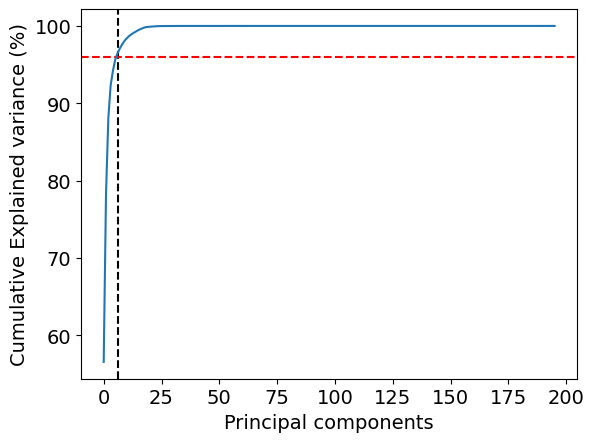

In [8]:
image = load_rst_npy.reshape(num_sample,-1)


pca = PCA()
pca.fit(image)

# Getting the cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>96)
print("Number of components explaining 99% variance: "+ str(k))
#print("\n")


# plt.figure(figsize=[10,5])
# plt.title('Cumulative Explained Variance explained by component')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative Explained variance (%)', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=96, color="r", linestyle="--")
ax = plt.plot(var_cumu)

#### Test: using PCs to reconstruct raw images

In [9]:
ipca = IncrementalPCA(n_components=k)
myPCs = ipca.fit_transform(image)
image_recon = ipca.inverse_transform(ipca.fit_transform(image))


Save PCs if needed

In [ ]:
# np.save('../pyDGSA/data/video_PCs.npy', myPCs)

The L2 error of demo case10 after 5 year of injection is: 0.015525234449157967 ft


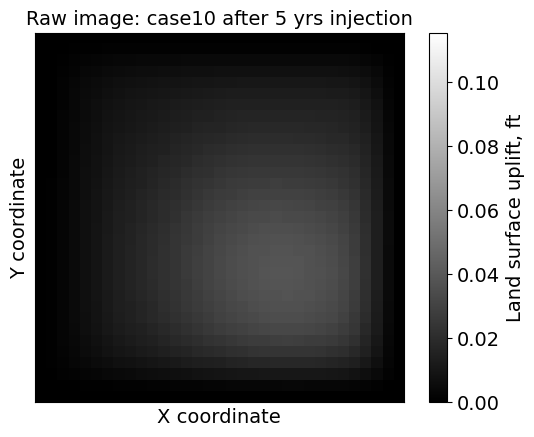

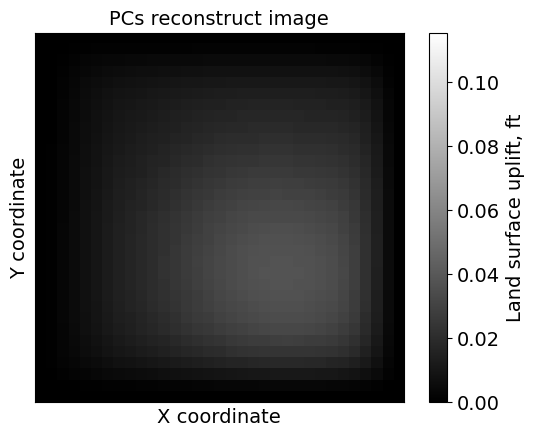

In [13]:
demo_idx = 10
demo_time = 5

l2_err = np.sqrt(np.sum((image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time] - image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time])**2))
print(f'The L2 error of demo case{demo_idx} after {demo_time} year of injection is: {l2_err} ft')

# Plotting the reconstructed image
min_val=min(np.min(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]), np.min(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]))
max_val=max(np.max(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]), np.max(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]))

fig, ax = plt.subplots()
plt.imshow(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time],cmap = plt.cm.gray, vmin=0, vmax=3*max_val)
plt.xlabel('X coordinate', fontsize=14)
plt.ylabel('Y coordinate', fontsize=14)
plt.title(f'Raw image: case{demo_idx} after {demo_time} yrs injection', fontsize=14)
cbar = plt.colorbar()
cbar.set_label("Land surface uplift, ft", fontsize=14)
cbar.ax.tick_params(labelsize=14) 
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

fig, ax = plt.subplots()
plt.imshow(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time],cmap = plt.cm.gray, vmin=0, vmax=3*max_val)
plt.xlabel('X coordinate', fontsize=14)
plt.ylabel('Y coordinate', fontsize=14)
plt.title(f'PCs reconstruct image', fontsize=14)
cbar = plt.colorbar()
cbar.set_label("Land surface uplift, ft", fontsize=14)
cbar.ax.tick_params(labelsize=14) 
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

## DGSA work

In [27]:

parameters = dfexpX.values
responses = myPCs

parameter_names = dfexpX.columns.to_list()


In [28]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [54]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 4
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [55]:
from pyDGSA.dgsa import dgsa

mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.907117    0.355461
E_sand, psi           1.650728    0.756243
v_shale               0.267407    0.119240
v_sand                0.863322    0.374727
kvkh                  0.474477    0.180053
inj_rate, ft3/day     1.517013    0.678228
inj_hrzn, year        1.824688    0.782050


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [56]:
# cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]


cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3  Cluster4
E_shale, psi       0.610320  0.975160  1.540445  1.430100
E_sand, psi        1.625222  2.125626  2.440313  2.367797
v_shale            0.244718  0.333372  0.541145  0.270642
v_sand             1.902147  1.784763  0.413795  0.403189
kvkh               0.361617  0.874357  0.423094  0.747215
inj_rate, ft3/day  1.920559  1.889918  1.840147  2.281274
inj_hrzn, year     1.956645  2.675822  3.138298  1.674017


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [57]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       1.052257
inj_rate, ft3/day | E_sand, psi       1.002319
kvkh | inj_hrzn, year                  0.92571
E_sand, psi | kvkh                    0.834762
E_sand, psi | E_shale, psi            0.799906
inj_hrzn, year | kvkh                 0.791332
kvkh | E_sand, psi                    0.753317
v_sand | E_shale, psi                 0.741121
E_shale, psi | v_shale                0.734806
inj_hrzn, year | E_shale, psi         0.707111
E_sand, psi | v_shale                 0.697208
kvkh | inj_rate, ft3/day              0.687731
E_shale, psi | E_sand, psi            0.685682
E_shale, psi | inj_hrzn, year          0.67897
inj_rate, ft3/day | kvkh              0.676889
kvkh | v_shale                        0.674755
inj_hrzn, year | inj_rate, ft3/day    0.659137
v_sand | inj_rate, ft3/day            0.655953
inj_rate, ft3/day | v_sand            0.650811
v_sand | v_shale                      0.649104
E_shale, psi 

Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [58]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       0.872442
inj_rate, ft3/day | E_sand, psi       0.857735
kvkh | inj_hrzn, year                 0.806586
E_sand, psi | inj_hrzn, year          0.801316
E_shale, psi | E_sand, psi            0.786386
E_sand, psi | E_shale, psi            0.762195
inj_hrzn, year | kvkh                  0.74634
E_shale, psi | v_sand                 0.733311
inj_hrzn, year | inj_rate, ft3/day    0.722103
inj_hrzn, year | E_sand, psi          0.713792
E_sand, psi | v_shale                 0.695306
E_sand, psi | kvkh                    0.675079
v_sand | E_sand, psi                  0.674178
inj_hrzn, year | v_sand               0.671805
E_sand, psi | v_sand                  0.669269
E_shale, psi | inj_hrzn, year         0.668031
kvkh | v_shale                        0.654581
E_shale, psi | v_shale                0.653726
v_sand | inj_rate, ft3/day            0.649297
kvkh | inj_rate, ft3/day              0.643895
inj_hrzn, yea

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [59]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3  Cluster4
E_sand, psi | E_shale, psi          0.991609  0.504178  1.192277  0.474165
v_shale | E_shale, psi              0.550112  0.516007  0.646119  0.639859
v_sand | E_shale, psi               0.681736  0.868387  0.730113  0.669019
kvkh | E_shale, psi                 0.682207  0.658455    0.5521  0.493284
inj_rate, ft3/day | E_shale, psi    0.306036  0.681399  0.549054  0.394825
inj_hrzn, year | E_shale, psi       0.385766  0.805175  0.871222  0.762818
E_shale, psi | E_sand, psi           0.81113  0.442562   1.00288   0.45223
v_shale | E_sand, psi               0.464147  0.497586  0.372931  0.462876
v_sand | E_sand, psi                0.736958  0.686145  0.478723  0.507785
kvkh | E_sand, psi                  1.051511  0.410405  0.563096  0.977889
inj_rate, ft3/day | E_sand, psi     1.136487  1.178646  0.780145  0.911314
inj_hrzn, year | E_sand, psi         0.31745  0.636249  0.417853  0.802061
E_shale, psi | v_shale   

To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [60]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi             0.887  0.880178  1.171061  0.184599   
v_shale | E_shale, psi              0.456323  0.590559  0.577175  0.366816   
v_sand | E_shale, psi               0.514746  1.010756  0.488166  1.063589   
kvkh | E_shale, psi                 0.773385  0.903522  0.322903  0.702084   
inj_rate, ft3/day | E_shale, psi    0.321942  0.245236  0.349524   0.73729   
inj_hrzn, year | E_shale, psi       0.255718   0.47048  0.414839  0.912982   
E_shale, psi | E_sand, psi          0.811945  1.078758  0.577008  0.432809   
v_shale | E_sand, psi               0.156241  0.518117  0.695128  0.525297   
v_sand | E_sand, psi                1.015874  0.262322  0.912583  0.657123   
kvkh | E_sand, psi                  0.767679  1.095503  1.294189   0.31555   
inj_rate, ft3/day | E_sand, psi     1.390997  0.426446  1.559625

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

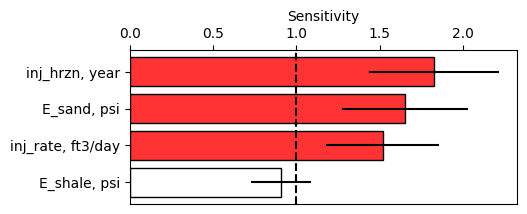

In [69]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

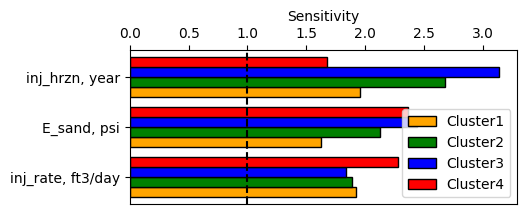

In [70]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'blue', 'red', 'black']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=3, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

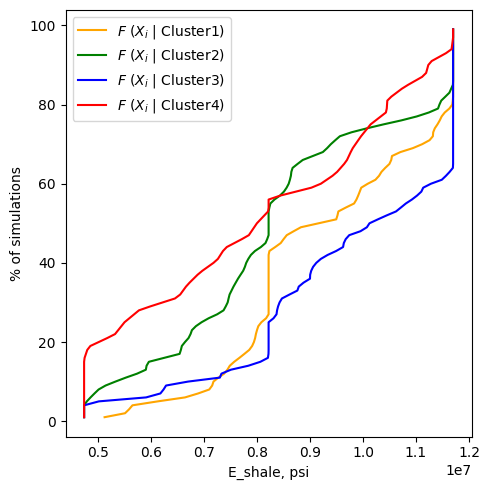

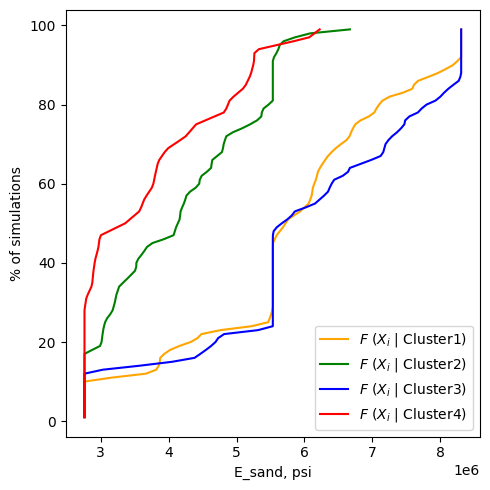

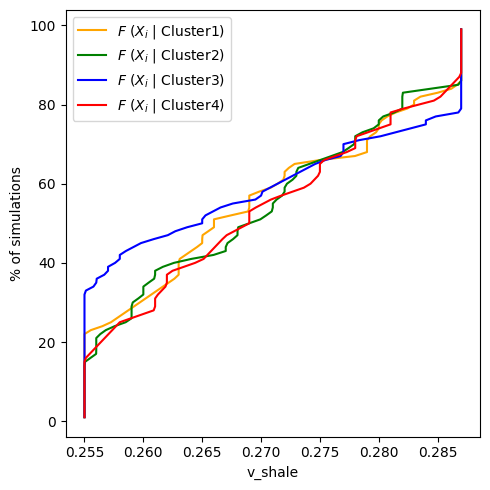

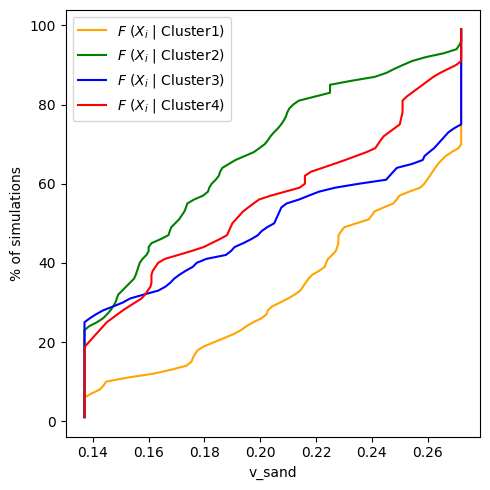

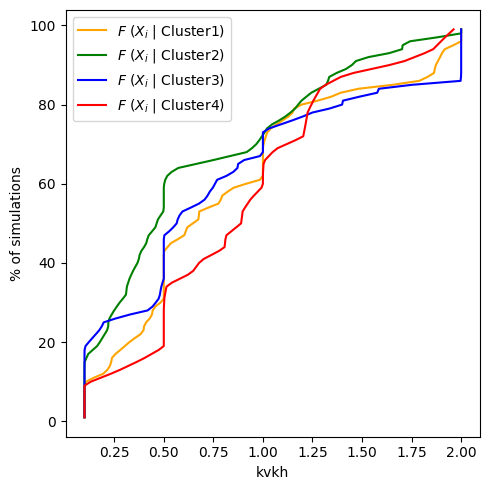

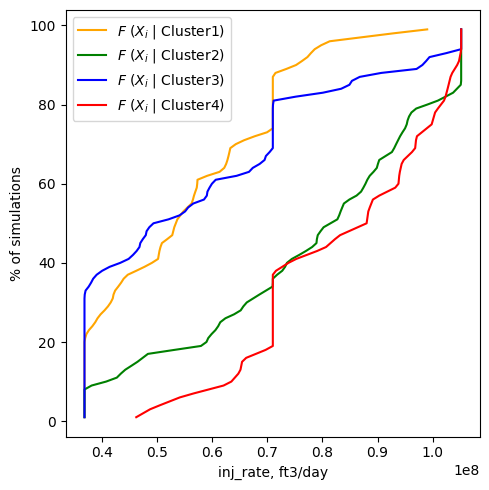

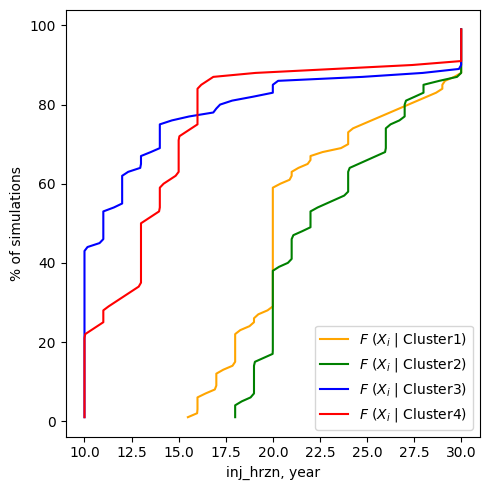

In [71]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

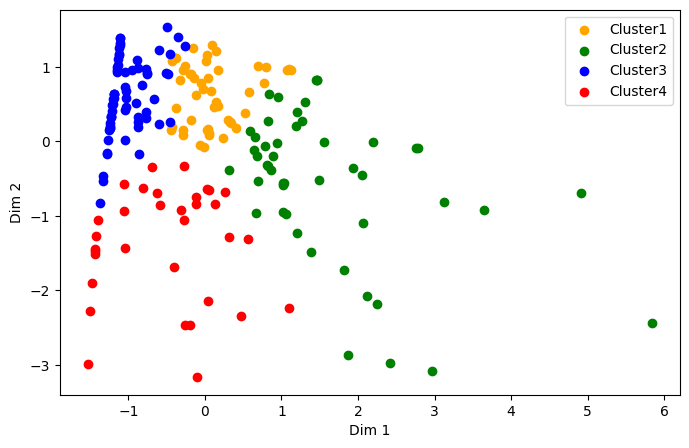

In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

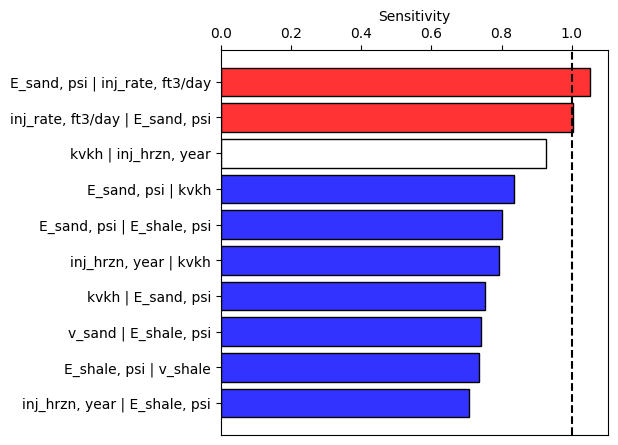

In [73]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

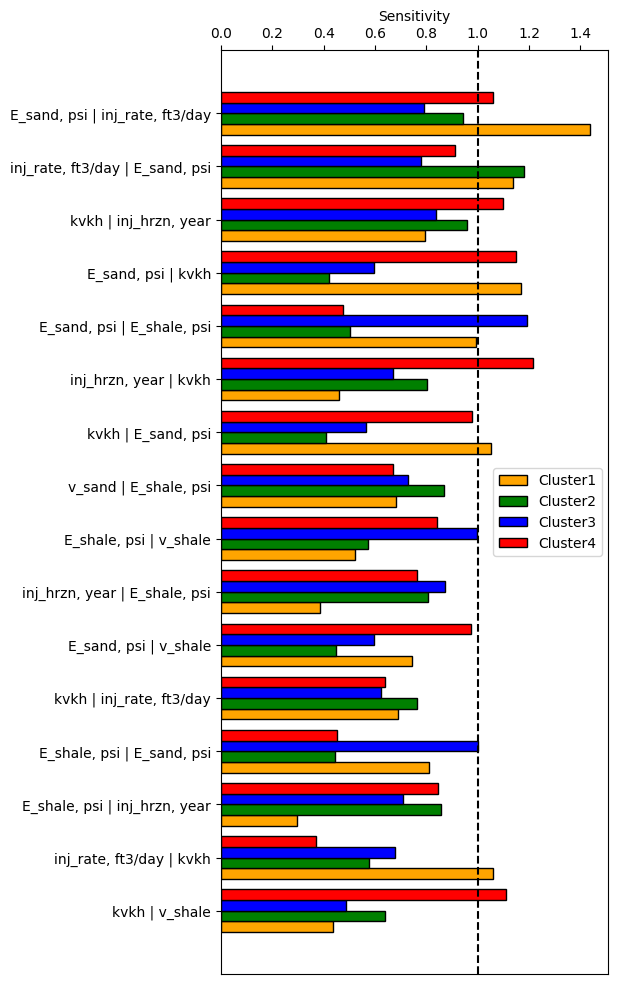

In [74]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

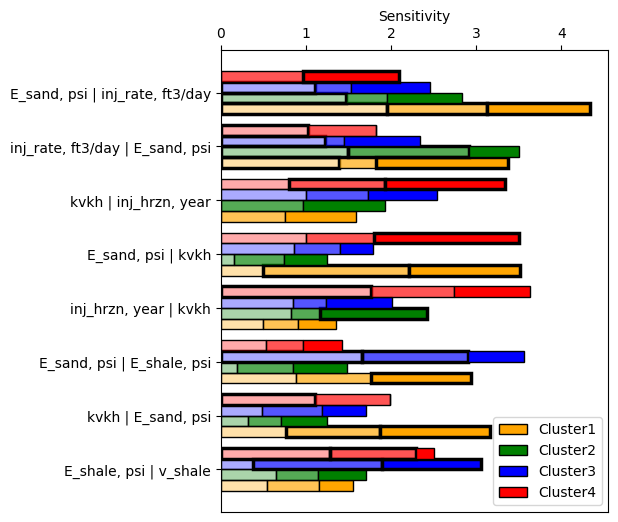

In [75]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)